# Neural Network from Scratch

Notebook will be used to construct a neural network from scratch -- will be helpful in showing different components and steps to creating a neural net. 

We will not be using any pre-built architectures, optimizers, or data loading frameworks.

[source 1](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch)

## Download Data from Kaggle

In [11]:
# install dependencies
import os
from pathlib import Path

In [12]:
# determine if we are running in a kaggle notebook
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: 
    path = Path('../input/titanic')
else: 
    path = Path('titanic')
    if not path.exists():
        import zipfile, kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 5.19MB/s]

Data from Kaggle competitions always lives in the `../input` folder

## Import Necessary Libraries and Set Display Settings

In [13]:
import torch
import pandas as pd, numpy as np 
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Clean Data

We are working with the titanic dataset. Data is provided in a tabular format in the form of a CSV

In [15]:
# read data into pandas dataframe
df = pd.read_csv(path/'train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To build our neural network, we will want to multiply each column by some coefficients. First, to ensure no errors, we need to handle missing values. 

#### Missing Values

In [16]:
# check for missing values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [17]:
# replace missing values with the most common value -- the "mode"
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [18]:
# fill missing values with the modes 
df.fillna(modes, inplace=True)

In [19]:
# confirm no more missing values
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

#### Summary Statistics of Numeric Columns

In [21]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


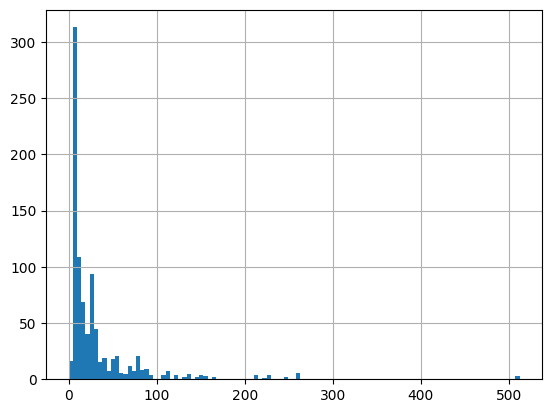

In [22]:
# preview histogram of fare
df['Fare'].hist(bins='auto');

We have some significant skew here -- the most common approach to address this will be to take the logarithm. 

Need to note that there are zeros in the `Fare` column, and `log(0)` is infinite -- to fix this, we'll simply add `1` to all values first:

In [23]:
df['LogFare'] = np.log(df['Fare'] + 1)

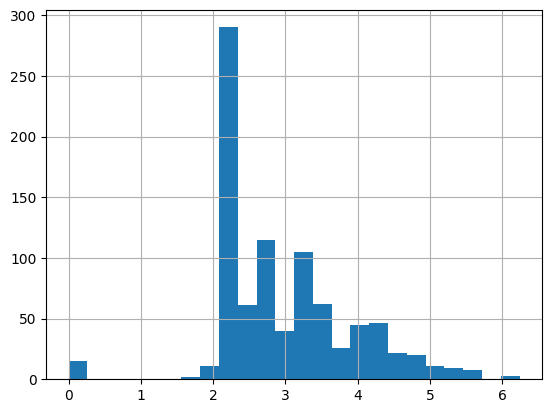

In [24]:
# reprint histogram
df['LogFare'].hist(bins='auto');

#### Confirm `Pclass` contains just 3 values

In [25]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [26]:
# summary of all non-numeric columns 
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


#### Handle Categorical Columns

In [27]:
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [28]:
# preview new columns
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2',
              'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


#### Setup Independent and Dependent Variables

In [29]:
from torch import tensor 

# specify dependent variable
t_dep = tensor(df['Survived'])

# specify independent columns 
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols
t_indep = tensor(df[indep_cols].values, dtype=torch.float)

In [33]:
# preview target   
print(t_dep.shape)

torch.Size([891])


In [34]:
# preview predictors
print(t_indep.shape)

torch.Size([891, 12])


We can see we have 891 rows, and 12 columns in our tensor

## Construct Linear Model

Our first model will be a simple linear model -- we'll need a coefficient for each column in `t_inep`. We'll pick numbers in the range `(-0.5, 0.5)`, and set our manual seed for reproducibility.